In [1]:
include("td_eta.jl")
include("main.jl");

In [5]:
using Random, Distributions, LinearAlgebra, Interpolations, Plots
using Pipe: @pipe

In [6]:
t = 1:100 |> collect                       # objective time
T = floor(Int, length(t)*0.4)              # reward time
r = zeros(length(t)-1); r[T] = 1           # reward schedule

# Gershman (2014) showed that ramping RPEs follow from convex functions
V = t.^4                # or any other sufficiently convex function
V[T+1:end] .= 0
V = V .* maximum(r)/maximum(V)  # renormalize so max(V) = r(T)

# RPE
gamma = .95
d = r + gamma*V[2:end]-V[1:end-1]

# account for temporal uncertainty following Weber's law
w = .2                         # Weber fraction
k = hcat([pdf.(dist, t) for dist in Normal.(t, w .*t)]...)
k0 = k[1:end-1, 1:end-1]

# take convolution with uncertainty kernels
Vh = (V' * k)'
dh = (d' * k0)'
Vdot = (diff(V)' * k0)'

# get baseline eta
η_base, Ys_base = TDeta(length(t)-1, T, 1, 1, Vh', r[T], gamma)
eta0 = η_base[end]

# learn eta for when reward earlier than expected
Tearly = round(Int, .6666*T)
η_early, Ys_early = TDeta(length(t)-1, Tearly, eta0, 1, Vh', r[T], gamma)
etaE = η_early[end]

# learn eta for when reward later than expected
Tlate = round(Int, 1.5*T)
η_late, Ys_late = TDeta(length(t)-1, Tlate, eta0, 1, Vh', r[T], gamma)
etaL = η_late[end];

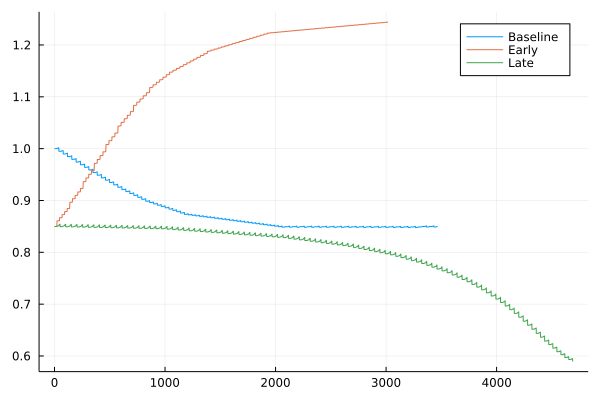

In [7]:
plot()

plot!(η_base, label="Baseline")
plot!(η_early, label="Early")
plot!(η_late, label="Late")

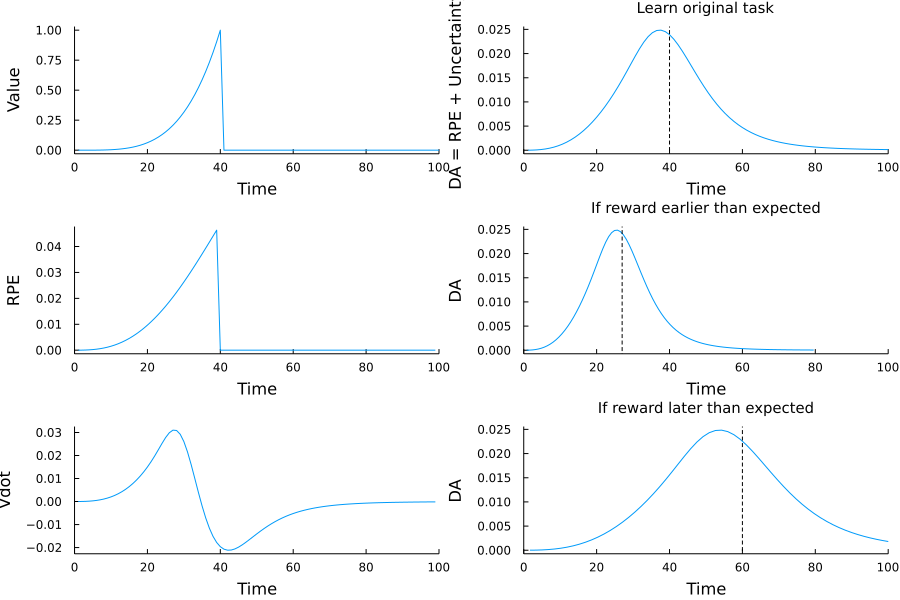

In [8]:
p1 = plot(V)
ylabel!("Value")

p2 = plot(d)
ylabel!("RPE")

p3 = plot(Vdot)
ylabel!("Vdot")

p4 = plot()
plot!(t[1:end-1]/eta0, dh)
vline!([t[T]], color=:black, linestyle=:dash)
ylabel!("DA = RPE + Uncertainty")
title!("Learn original task")

p5 = plot()
plot!(t[1:end-1]/etaE, dh)
vline!([t[Tearly]], color=:black, linestyle=:dash)
ylabel!("DA")
title!("If reward earlier than expected")

p6 = plot()
plot!(t[1:end-1]/etaL, dh)
vline!([t[Tlate]], color=:black, linestyle=:dash)
ylabel!("DA")
title!("If reward later than expected")

layout = @layout([
    a b
    c d
    e f
])
plot(p1, p4, p2, p5, p3, p6,
    size=(900, 600),
    xlim=(0, maximum(t)),
    grid=:off,
    xlabel="Time",
    legend=nothing,
    titlefont=font(10, :bold),
    layout=layout
)

In [561]:
function getda(Ys, T, t, dh)
    da = DataFrame(trial=Int[], lick=Float64[], eta=Float64[], t=Float64[], y=Float64[])
    damaxidx = findmax(dh)[2]

    for (i, Y) in enumerate(Ys)
        η = Y / T
        x = t[1:end-1] ./ η

        # add rows
        append!(
            da,
            DataFrame(
                trial=repeat([i], length(x)),
                lick=repeat([x[damaxidx]], length(x)),
                eta=repeat([η], length(x)),
                t=x, 
                y=dh
            )
        )
    end
    
    return da
end

da_base = getda(Ys_base, T, t, dh)
da_early = getda(Ys_early, Tearly, t, dh)
da_late = getda(Ys_late, Tlate, t, dh);

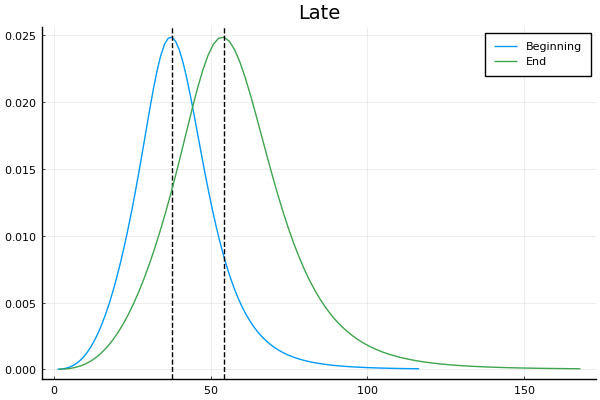

In [562]:
plot(da_late.t[da_late.trial .== 1], da_late.y[da_late.trial .== 1], label="Beginning")
vline!([da_late.lick[da_late.trial .== 1] |> unique], color=:black, linestyle=:dash, label="")

i = unique(da_late.trial)[end]
plot!(da_late.t[da_late.trial .== i], da_late.y[da_late.trial .== i], label="End")
vline!([da_late.lick[da_late.trial .== i] |> unique], color=:black, linestyle=:dash, label="")

title!("Late")

In [563]:
function getslopes(da)
    trials = unique(da.trial)
    slopes = zeros(length(trials))

    # compute slopes
    for (i, trial) in enumerate(trials)
        trialda = da[da.trial .== trial, :]
        lick = trialda.lick[1]
        
        x = trialda.t[trialda.t .<= lick]
        y = trialda.y[trialda.t .<= lick]
        
        f = LinearInterpolation(x, y, extrapolation_bc=Line())
        xx = collect(0:0.05:lick)
        yy = f.(xx)
        
        # slope between 0 and lick
        ols = lm(@formula(y ~ x), DataFrame(x=xx, y=yy))
        slope = coef(ols)[2]
        slopes[i] = slope
    end
    
    return slopes
end

function getdabins(da, tlen=100, nbins=20)
    trials = unique(da.trial)
    dabins = zeros(length(trials), nbins)
    lim = div(nbins, 2)
    
    # compute da levels in each bin
    for (i, trial) in enumerate(trials)
        trialda = da[da.trial .== trial, :]
        lick = trialda.lick[1]
        
        x = trialda.t; y = trialda.y
        f = LinearInterpolation(x, y, extrapolation_bc=Line())
        
        triallen = tlen
        #triallen = maximum(trialda.t)
        #lim = div(nbins, 2)
        #binlen_prev = (1.0 / nbins) * (lick - 0) * 2
        #binlen_after = (1.0 / nbins) * (triallen - lick) * 2
        
        #bins = vcat(lick .+ collect(-lim:0) .* binlen_prev, lick .+ collect(1:lim) .* binlen_after)
        
        bins = lick .+ collect(-lim:lim) * (triallen / nbins)
        
        dabins[i,:] = map(1:nbins) do j
            if (bins[j+1] < 0) || (bins[j] > triallen)
                return 0.0
            #elseif bins[j] < x[1] || bins[j+1] > x[end]
            #    a = max(x[1], bins[j])
            #    b = min(x[end], bins[j+1])
            #    
            #    return mean(f.(a:0.1:b))
            else
                xx = collect(bins[j]:0.05:bins[j+1])
                return mean(f.(xx))
            end
        end
        
        if any(isnan.(dabins[i,:]))
            println("NaN at trial $i")
        end
    end
    
    return DataFrame(dabins, :auto)
end
;

In [564]:
slopes_base = getslopes(da_base)
slopes_early = getslopes(da_early)
slopes_late = getslopes(da_late);

In [628]:
nbins = 70; lim = div(nbins, 2)
tlen = length(t)

dabins_base = getdabins(da_base, tlen, nbins)
dabins_early = getdabins(da_early, tlen, nbins)
dabins_late = getdabins(da_late, tlen, nbins);

In [629]:
function plot_dabins(dabins)
    Matrix(dabins)[1,:] |> plot
    Matrix(dabins)[end,:] |> plot!
end;

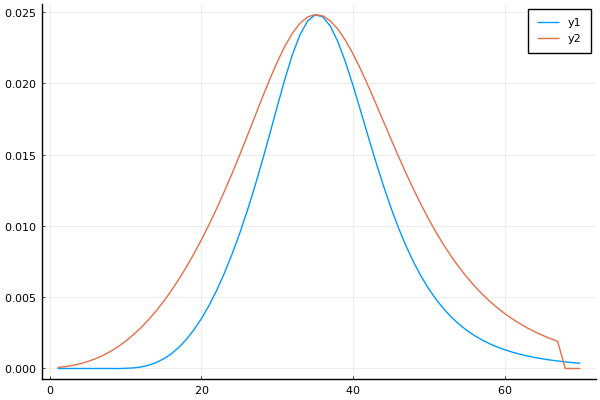

In [630]:
plot_dabins(dabins_late)

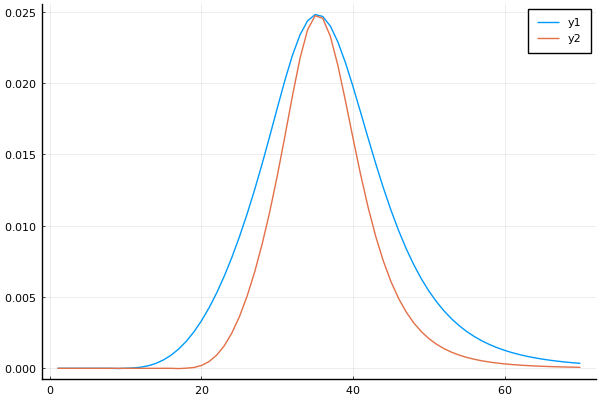

In [631]:
plot_dabins(dabins_early)

In [632]:
# concat all "sessions"
da_all = vcat(da_early, da_late)
da_all.session = vec(repeat([2 3], nrow(da_base)))

dabins_all = vcat(dabins_early, dabins_late)
dabins_all.session = vec(repeat([2 3], nrow(dabins_base)))

slopes_all = vcat(slopes_early, slopes_late)
;

In [633]:
minimum(da_all.lick), maximum(da_all.lick)

(25.718568323827725, 54.287324369092886)

In [640]:
rev = false

filterbin = [minimum(da_all.lick)-1, maximum(da_all.lick)+1]

da = dabins_all |> copy
slopes = slopes_all |> copy
# filter by timebin
df = nothing
for session in unique(da_all.session)
    trials = combine(first, groupby(da_all[da_all.session .== session,:], :trial))
    binidx = filterbin[1] .<= trials.lick .<= filterbin[2]
    
    trialda = da[da.session .== session,:][binidx,:]
    trialslopes = slopes[da.session .== session][binidx]
    #etas = etas[binidx]
    
    indexes = collect(1:nrow(trialda)-1)
    Δtrialslopes = (trialslopes[2:end] .- trialslopes[1:end-1])[indexes]
    
    if rev
        Δtrialslopes .*= -1
        indexes .+= 1
    end
    
    df_trial = trialda[indexes,:]
    df_trial.a = Δtrialslopes

    if df == nothing
        df = df_trial
    else
        append!(df, df_trial)
    end
end

formula = Term(:a) ~ ConstantTerm(0) + sum(Term.(Symbol.(names(dabins_base))))
ols     = lm(formula, df)
y       = replace(coef(ols),     NaN => 0)
stderr  = replace(stderror(ols), NaN => 0)

bins = mean(filterbin) .+ collect(-lim:lim) .* (tlen / nbins)
x = (bins[1:end-1] + bins[2:end]) / 2.0
;

In [641]:
nrow(df)

198

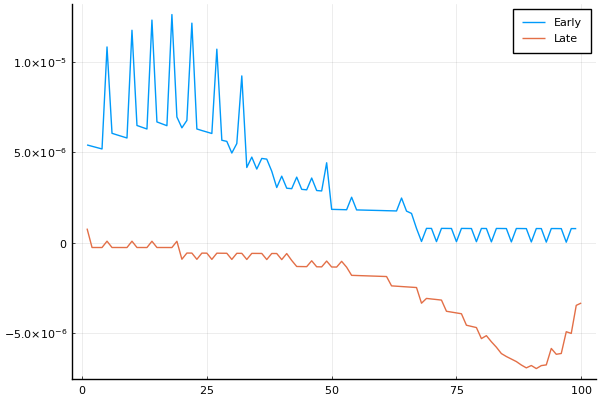

In [642]:
plot()
plot!(df.a[1:round(Int, nrow(df)/2)],   label="Early")
plot!(df.a[round(Int, nrow(df)/2):end], label="Late")

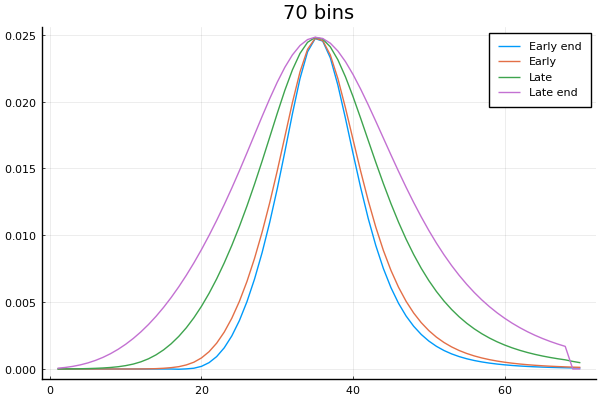

In [643]:
plot()

@pipe Matrix(df[:,"x" .* string.(1:nbins)])[round(Int,nrow(df)/2),:] |> vec |> plot!(_, label="Early end") 
@pipe df[1:round(Int, nrow(df)/2),   "x" .* string.(1:nbins)] |> Matrix |> mean(_, dims=1) |> vec |> plot!(_, label="Early") 
@pipe df[round(Int, nrow(df)/2):end, "x" .* string.(1:nbins)] |> Matrix |> mean(_, dims=1) |> vec |> plot!(_, label="Late")  
@pipe Matrix(df[:,"x" .* string.(1:nbins)])[end,:] |> vec |> plot!(_, label="Late end") 

title!("$nbins bins")

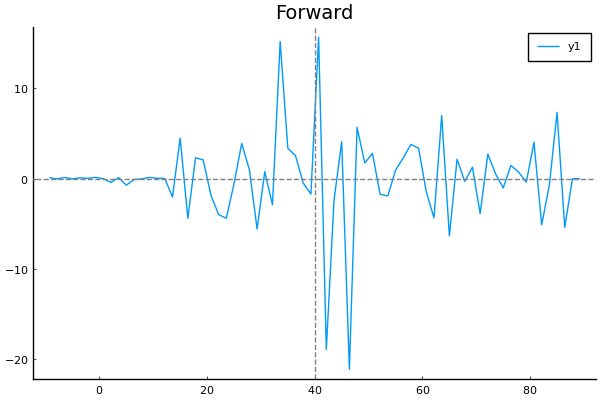

In [644]:
yplot = @pipe y |> smooth(_, :cosine, 1)
plot(x, yplot, grid=:off) #, ribbon=stderr)
vline!([t[round(Int, mean(filterbin))]], color=:gray, linestyle=:dash, label="")
hline!([0], color=:gray, linestyle=:dash, label="")
title!(rev ? "Reverse" : "Forward")
#plot!(xlim=(0, 80))
#plot!ylim=(-0.05, 0.05))

#plot!()

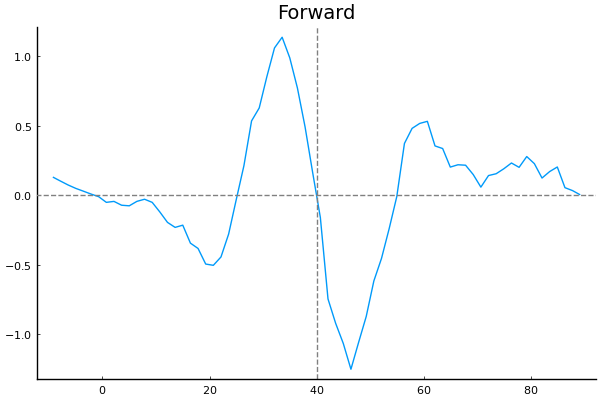

In [651]:
yplot = @pipe y |> smooth(_, :rect, 10)
p_for = plot(x, yplot, grid=:off, label="") #, ribbon=stderr)
vline!([t[round(Int, mean(filterbin))]], color=:gray, linestyle=:dash, label="")
hline!([0], color=:gray, linestyle=:dash, label="")
title!(rev ? "Reverse" : "Forward")
#plot!(xlim=(0, 80))
#plot!ylim=(-0.05, 0.05))

#plot!()

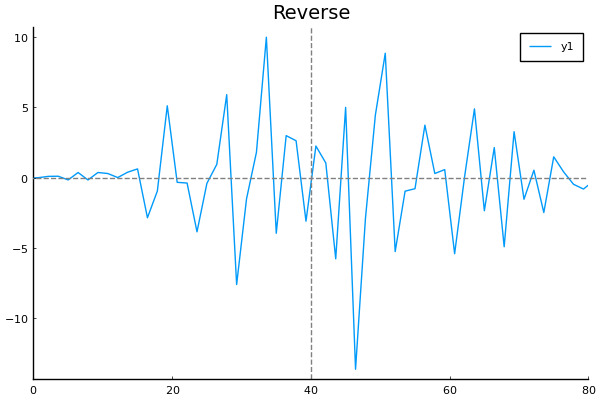

In [638]:
yplot = @pipe y |> smooth(_, :cosine, 1)
plot(x, yplot, grid=:off) #, ribbon=stderr)
vline!([t[round(Int, mean(filterbin))]], color=:gray, linestyle=:dash, label="")
hline!([0], color=:gray, linestyle=:dash, label="")
title!(rev ? "Reverse" : "Forward")
plot!(xlim=(0, 80))
#plot!ylim=(-0.05, 0.05))

#plot!()

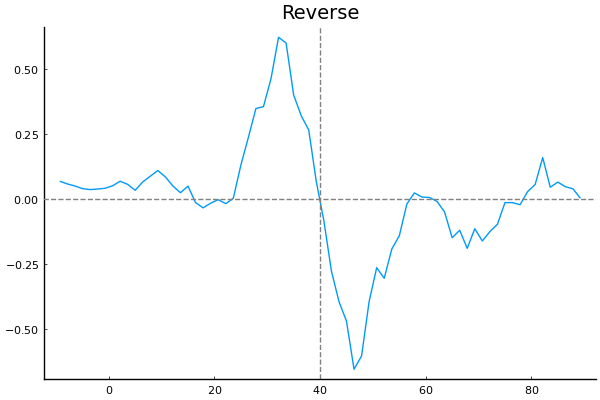

In [639]:
yplot = @pipe y |> smooth(_, :rect, 10)
p_rev = plot(x, yplot, grid=:off, label="") #, ribbon=stderr)
vline!([t[round(Int, mean(filterbin))]], color=:gray, linestyle=:dash, label="")
hline!([0], color=:gray, linestyle=:dash, label="")
title!(rev ? "Reverse" : "Forward")
#plot!(xlim=(0, 80))
#plot!ylim=(-0.05, 0.05))

#plot!()

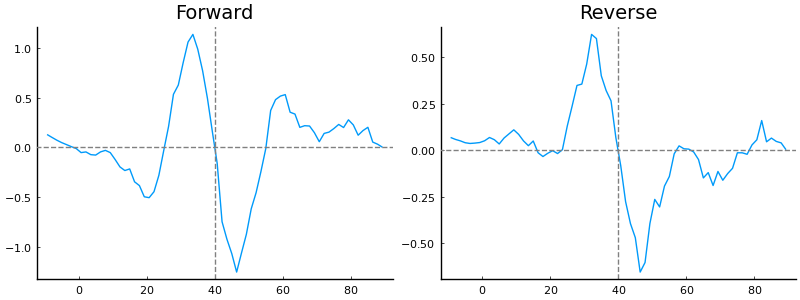

In [653]:
plot(p_for, p_rev,
    size=(800, 300),
    layout=@layout([ a b ]))

In [654]:
savefig("figs/discussion/simulation.png")